# Proyecto – Entrega 3

**Curso:** CI-0115  
**Profesor:** Sebastián Ruiz Blais  
**Semestre:** I-2024  
**Grupo:** 3  
**Estudiantes:**  
- Ignacio Redondo Alfaro C06420  
- Braunny Madrigal Barrantes C24436  

---

## 0.

Preprocesar y filtrar la base de datos. Se deja limpia para su uso en los puntos siguientes.

---

In [157]:

# --------------------------IMPORTING PACKAGES----------------------------------------------------------------------------
# Data manipulation and analysis
import pandas as pd

# Plotting and visualization
from matplotlib import pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

# Statistical analysis
from scipy.stats import f_oneway
from scipy.stats import shapiro
from scipy.optimize import curve_fit
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats

# Math
import numpy as np  # to manipulate a matrix
import math  # to calc the square root
#-------------------------------------------------------------------------------------------------------------------------

#------------------------CREATING A SPEC DATASET BASED ON A GIVEN FILEPATH------------------------------------------------
my_data = pd.read_csv('world_development.csv', sep = ',', skipinitialspace = True)
#-------------------------------------------------------------------------------------------------------------------------

#------------------------------------DROP DATAFRAME SPECIFIC COLUMNS IN A RANGE-------------------------------------------
def drop_columns_in_range(data, column_start, column_end):
    data = data.drop(data.columns[column_start:column_end], axis=1)
    return data
#-------------------------------------------------------------------------------------------------------------------------

#------------------------------DROP EVERY ROW THAT CONTAINS A NAN VALUE ON SPECIFIC COLUMN TITLE--------------------------
def drop_nan_rows_in_spec_col(data, column_title):
    data = data.dropna(subset=[column_title])
    return data
#-------------------------------------------------------------------------------------------------------------------------

#----------------------DROP EVERY ROW OUTSIDE THE FIRST INDEX ROWS PATTERN------------------------------------------------
def drop_rows_outside_of_pattern(data, rows_to_keep, number_unique_rows, number_set_rows):
    final_data = pd.DataFrame() 
    for i in range(number_set_rows):  # Repeat the process for each set of number_unique_rows
        base_index = i * number_unique_rows  # Calculate the base index of the rows for this iteration
        rows_to_keep_shifted = [idx + base_index for idx in rows_to_keep]   # rows to keep for this iteration
        final_data = pd.concat([final_data, data.loc[rows_to_keep_shifted]])
    return final_data
#-------------------------------------------------------------------------------------------------------------------------

#------------------DROP ROWS IN A SPECIFIC COLUMN IF THE ROW VALUE IS NOT REPEATED AT LEAST N TIMES-----------------------
def drop_rows_in_speccol_that_appear_less_than_ntimes(data, spec_col, n_times):
    data = data.groupby(spec_col).filter(lambda x : len(x)>n_times)
    return data
#-------------------------------------------------------------------------------------------------------------------------

#-----------------REPLACE OLD LIST OF ROW NAMES IN SPEC COL WITH NEW LIST OF ROW NAMES------------------------------------
def replace_old_row_names_with_new_in_spec_col(data, spec_col, old_names, new_names):
    data[spec_col] = data[spec_col].replace(old_names, new_names)
    return data
#-------------------------------------------------------------------------------------------------------------------------

#------------------DIVIDE ROWS, STARTING IN START, MULTIPLES OF INCREMENT IN SPEC COL BY A GIVEN VALUE--------------------
def divide_spec_rows_in_col_by_val(data, spec_col, start, increment, value):
    num_rows = data.shape[0]
    i = start
    while(i < num_rows):
        data.at[i, spec_col] = data.at[i, spec_col] / value
        i += increment
    return data
#-------------------------------------------------------------------------------------------------------------------------

#--------------------------GET SPEC_INDICATOR VALUES ON EACH YEAR AND RETURN IT AS A LIST---------------------------------
def get_spec_indicator_values_on_each_year(data, spec_ind, list_return):
    for i in range (spec_ind, 760, 5):  # Starts iterating on the spec_ind value, that way passes for all years
        for j in range(2000, 2020):
            value = data.at[i, str(j)]
            list_return.append(value)
    return list_return
#-------------------------------------------------------------------------------------------------------------------------

#-------------------CREATE CATEGORIES OF POPULATION-----------------------------------------------------------------------
def categorize_population(df, population_column='Population_Millions', labels=['Small', 'Medium', 'Large']):
    quantiles = df[population_column].quantile([0.33, 0.66]).values
    def categorize_population_inner(population):  # Función para asignar etiquetas según el tamaño de la población
        if population <= quantiles[0]:
            return labels[0]
        elif population <= quantiles[1]:
            return labels[1]
        else:
            return labels[2]
    df['Size_Population'] = df[population_column].apply(categorize_population_inner)  # Aplicar la función para categorizar
    return df
#-------------------------------------------------------------------------------------------------------------------------

#------------OBTAINING NEW DATA FRAME AND DOING PREPROCESSING-------------------------------------------------------------
my_countries = pd.read_csv('countries.csv', sep = ',', skipinitialspace = True)
my_rice =  pd.read_csv('rice_production.csv', sep = ',', skipinitialspace = True)
my_co2 = pd.read_csv('co2_emissions.csv', sep = ',', skipinitialspace = True)
my_countries = my_countries[['nombre', 'name', 'iso3']]
my_rice = my_rice.drop(columns=['Unit', 'Flag', 'Flag Description']) 
my_co2 = my_co2.drop(columns=['ISO 3166-1 alpha-3', 'Total', 'Gas', 'Flaring', 'Other', 'Per Capita'])
#-------------------------------------------------------------------------------------------------------------------------

#------------------------------------PREPROCESS---------------------------------------------------------------------------
def main_00():
    # Make a copy of the original data
    new_data = my_data.copy()
    # Drop columns from 4 to 44
    new_data = drop_columns_in_range(new_data, 3, 44)
    # Drop columns from 24 to 40
    new_data = drop_columns_in_range(new_data, 23, 40)
    # Drop column 1 (originally column 0)
    new_data = drop_columns_in_range(new_data, 1, 2)
    # Drop every row outside of the selected row. Useful when working with indicators on a single column
    new_data = drop_rows_outside_of_pattern(new_data, [1, 18, 34, 61, 67], 76, 266)
    # Drop rows with null values in the 'Country Name' column title
    new_data = drop_nan_rows_in_spec_col(new_data, 'Country Name')
    # Drop rows with null values in each one the selected years
    for i in range(2000, 2020):
        new_data = drop_nan_rows_in_spec_col(new_data, str(i))

    # Drop countries that are not repeated at least more than 4 times
    new_data = drop_rows_in_speccol_that_appear_less_than_ntimes(new_data, 'Country Name', 4)
    # Reset the DataFrame's indexes after dropping rows
    new_data.reset_index(drop=True, inplace=True)
    # Initialize both row names lists
    old_row_names = ['Población urbana', 'Extracción anual de agua dulce, total (en billones de metros cúbicos)', 'Emisiones de gases de efecto invernadero totales (kt de equivalente de CO2)', 'Acceso a la electricidad (% de población)', 'Área selvática  (kilómetros cuadrados)']
    new_row_names = ['Population_Millions', 'H2O_Extraction_Billions', 'GHG_Emissions_KT', 'Electricity_Access_%', 'Forest_Area_KM2']
    # Replace old_row_names with the new_row_names
    new_data = replace_old_row_names_with_new_in_spec_col(new_data, 'Indicator Name', old_row_names, new_row_names)
    # Divide the Indicator Population_Millions to make actually a population represented in millions
    for i in range(2000, 2020):
        new_data = divide_spec_rows_in_col_by_val(new_data,str(i), 0, 5, 1000000)

    # Lists with values on each new column title
    list_countries = []
    list_years = []
    list_pop = []
    list_water = []
    list_ghg = []
    list_elect = []
    list_forest = []

    # Get countries in the data frame
    for i in range(0, 760, 5):
        curr_country = new_data.iat[i, 0]
        for j in range(i, i+20):
            list_countries.append(curr_country)  # Repeat each country for the amount of years
          
    # Get each year on the dataframe
    for i in range(2000, 2020):
        list_years.append(i)
    list_years = 152*list_years  # Repeat each year for each country
    
    # Get Population_Millions value on each year
    list_pop = get_spec_indicator_values_on_each_year(new_data, 0, list_pop)
    # Get H2O_Extraction_Billions value on each year
    list_water = get_spec_indicator_values_on_each_year(new_data, 1, list_water)
    # Get GHG_Emissions_KT value on each year
    list_ghg = get_spec_indicator_values_on_each_year(new_data, 2, list_ghg)
    # Get Electricity_Access_% value on each year
    list_elect = get_spec_indicator_values_on_each_year(new_data, 3, list_elect)
    # Get Forest_Area_KM2
    list_forest = get_spec_indicator_values_on_each_year(new_data, 4, list_forest)

    column_names = ['Country', 'Year', 'Population_Millions', 'H2O_Extraction_Billions', 'GHG_Emissions_KT', 'Electricity_Access_%', 'Forest_Area_KM2']
    my_dict = {column_names[0] : list_countries, column_names[1] : list_years, column_names[2] : list_pop, column_names[3] : list_water, column_names[4] : list_ghg, column_names[5] : list_elect, column_names[6] : list_forest}
    final_data = pd.DataFrame.from_dict(my_dict)  # Create a new data frame which columns will be the different indicator names
    final_data = final_data.sort_values('Year')  # Sort the final data frame based on the column Year
    final_data = categorize_population(final_data)
    final_data = final_data.reset_index(drop=True)

    # rename columns that will serve as reference
    new_data = final_data.rename(columns={"Country": "nombre"})
    new_co2 = my_co2.rename(columns={"Country": "nombre"})
    new_rice = my_rice.rename(columns={"Area": "nombre", "Value": "Rice_T"})
    # unify dataframes using one common column as reference
    new_data = new_data.merge(my_countries, on=['nombre'])
    # unify dataframes using two columns as reference
    new_data = new_data.merge(new_co2, on=['nombre', 'Year'])
    new_data = new_data.merge(new_rice, on=['nombre', 'Year'])
    return new_data
#-------------------------------------------------------------------------------------------------------------------------

#----------------------INVOKE---------------------------------------------------------------------------------------------
my_data = main_00()
print(my_data)
#-------------------------------------------------------------------------------------------------------------------------


         nombre  Year  Population_Millions  H2O_Extraction_Billions  \
0      Paraguay  2000             2.835060                 0.490000   
1      Portugal  2000             5.597602                10.664667   
2         Nepal  2000             3.290236                 9.562500   
3     Nicaragua  2000             2.827250                 1.386681   
4         Chile  2000            13.213754                28.936629   
..          ...   ...                  ...                      ...   
739     Nigeria  2019           104.004479                12.472000   
740      Malawi  2019             3.240276                 1.356800   
741  Mauritania  2019             2.389505                 1.348200   
742  Mozambique  2019            11.062722                 1.473000   
743       Malta  2019             0.477236                 0.040905   

     GHG_Emissions_KT  Electricity_Access_%  Forest_Area_KM2 Size_Population  \
0        30409.209020             89.578857         229916.5       

## 1. (20%)

### Instrucción
Para cada una de las variables de interés, realizar pruebas de normalidad,utilizando ya sea el test Shapiro-Wilk o Kolmogorov-Smirnov (https://www.statology.org/normality-test-python/). Explicar el resultado obtenido. En caso de que los datos no estén distribuidos normalmente, aplicar una transformación a los datos para obtener una distribución normal. En caso de no obtener una distribución normal, probar por lo menos con dos tipos de transformaciones y documentar el proceso. Cuando realice su presentación, agregue este paso antes de realizar los ANOVA’s (que asumen una distribución normal). En caso de haber tenido que transformar los datos, vuelva a realizar los ANOVA’s para comprobar que no hubo cambios. Si no se pudo obtener una distribución normal utilizando una transformación de datos, omita realizar nuevos ANOVA’s. 

### Resolución

Preguntas sobre las variables de interes de la instrucción 1:

1. ¿Variable 'H2O_Extraction_Billions' según su categoría en 'Population_Size: Small, Medium, Large'?
2. ¿Variable 'Forest_Area_KM2' según su categoría en 'Population_Size: Small, Medium, Large'?
3. ¿Variable 'Rice_T' según su categoría en 'Population_Size: Small, Medium, Large'

---


In [158]:

#----------------------------SHAPIRO-WILK PARA UNA COLUMNA ESPECIFICA EN UN DATAFRAME-------------------------------------
def shapiro_wilk(df, column):
    print("Test de Shapiro-Wilk para la variable", column)
    print(shapiro(df[column]), "\n")
#-------------------------------------------------------------------------------------------------------------------------

#-------------------APLICAR TRANSFORMACIÓN DE TIPO RAIZ CUADRADA A UNA COLUMNA EN UN DATAFRAME----------------------------
def sqrt_trans(df, column):
    np.random.seed(0)  # hacer el ejemplo reproducible
    df[column] = np.sqrt(df[column])  # transformar la columna especifica de df
    return df
#-------------------------------------------------------------------------------------------------------------------------

#-------------------APLICAR TRANSFORMACIÓN DE TIPO RAIZ CUBICA A UNA COLUMNA EN UN DATAFRAME------------------------------
def cbrt_trans(df, column):
    np.random.seed(0)  # hacer el ejemplo reproducible
    df[column] = np.cbrt(df[column])  # transformar la columna especifica de df
    return df
#-------------------------------------------------------------------------------------------------------------------------

#-------------------------------------------------------------------------------------------------------------------------
def main_01():
    print("PRUEBAS DE NORMALIDAD EN EL DATAFRAME ORIGINAL.\n")
    shapiro_wilk(my_data, 'H2O_Extraction_Billions')  # prueba de normalidad para 'H2O_Extraction_Billions'
    shapiro_wilk(my_data, 'Forest_Area_KM2')  # prueba de normalidad para 'Forest_Area_KM2'
    shapiro_wilk(my_data, 'Rice_T')  # prueba de normalidad para 'Rice_T'
    print("Tenemos que los 'pvalue' de cada una de las 3 variables son menores que 'α =0.05'. Por tanto,")
    print("se rechaza la hipótesis nula. Lo anterior significa que hay suficiente evidencia para afirmar")
    print("que ninguna de las 3 variables evaluadas viene de una distribución normal.\n\n\n")
    
    df_sqrt = my_data.copy()  # hacer una copia de my_data para usarla en transformaciones de raiz cuadrada
    df_cbrt = my_data.copy()  # hacer una copia de my_data para usarla en transformaciones de raiz cubica
    
    df_sqrt = sqrt_trans(df_sqrt, 'H2O_Extraction_Billions')  # aplicar transformacion raiz cuadrada en columna 'H2O_Extraction_Billions'
    df_sqrt = sqrt_trans(df_sqrt, 'Forest_Area_KM2')  # aplicar transformacion raiz cuadrada en columna 'Forest_Area_KM2'
    df_sqrt = sqrt_trans(df_sqrt, 'Rice_T')  # aplicar transformacion raiz cuadrada en columna 'Rice_T'
    print("PRUEBAS DE NORMALIDAD EN EL DATAFRAME TRANSFORMADO MEDIANTE RAIZ CUADRADA.\n")
    shapiro_wilk(df_sqrt, 'H2O_Extraction_Billions')  # prueba de normalidad para 'H2O_Extraction_Billions' en df_sqrt
    shapiro_wilk(df_sqrt, 'Forest_Area_KM2')  # prueba de normalidad para 'Forest_Area_KM2' en df_sqrt
    shapiro_wilk(df_sqrt, 'Rice_T')  # prueba de normalidad para 'Rice_T' en df_sqrt
    print("Tenemos que los 'pvalue' siguen siendo menores que 'α =0.05'. Por tanto, cada una de las 3")
    print("variables sigue sin venir de una distribución normal.\n\n\n")

    df_cbrt = cbrt_trans(df_cbrt, 'H2O_Extraction_Billions')  # aplicar transformacion raiz cubica en columna 'H2O_Extraction_Billions'
    df_cbrt = cbrt_trans(df_cbrt, 'Forest_Area_KM2')  # aplicar transformacion raiz cubica en columna 'Forest_Area_KM2'
    df_cbrt = cbrt_trans(df_cbrt, 'Rice_T')  # aplicar transformacion raiz cubica en columna 'Rice_T'
    print("PRUEBAS DE NORMALIDAD EN EL DATAFRAME TRANSFORMADO MEDIANTE RAIZ CUBICA.\n")
    shapiro_wilk(df_cbrt, 'H2O_Extraction_Billions')  # prueba de normalidad para 'H2O_Extraction_Billions' en df_cbrt
    shapiro_wilk(df_cbrt, 'Forest_Area_KM2')  # prueba de normalidad para 'Forest_Area_KM2' en df_cbrt
    shapiro_wilk(df_cbrt, 'Rice_T')  # prueba de normalidad para 'Rice_T' en df_cbrt
    print("Tenemos que los 'pvalue' siguen siendo menores que 'α =0.05'. Por tanto, cada una de las 3")
    print("variables sigue sin venir de una distribución normal.\n\n\n")

    print("ANOVA's\n")
    print("Debido a que no fue posible obtener una distribución normal para ninguna de las variables de interes,")
    print("lo anterior habiendo sido intentado con 2 tipos distintos de transformación de datos, se sigue la ins-")
    print("trucción que dicta omitir el volver a realizar los ANOVA's en un caso como este.\n\n\n")
#-------------------------------------------------------------------------------------------------------------------------

#---------------------------------------------------------------INVOCAR---------------------------------------------------
main_01()
#-------------------------------------------------------------------------------------------------------------------------


PRUEBAS DE NORMALIDAD EN EL DATAFRAME ORIGINAL.

Test de Shapiro-Wilk para la variable H2O_Extraction_Billions
ShapiroResult(statistic=0.32131691430350406, pvalue=7.72791154668369e-46) 

Test de Shapiro-Wilk para la variable Forest_Area_KM2
ShapiroResult(statistic=0.6213584193615815, pvalue=1.8683523870487403e-37) 

Test de Shapiro-Wilk para la variable Rice_T
ShapiroResult(statistic=0.3099135158709677, pvalue=4.3227694922289625e-46) 

Tenemos que los 'pvalue' de cada una de las 3 variables son menores que 'α =0.05'. Por tanto,
se rechaza la hipótesis nula. Lo anterior significa que hay suficiente evidencia para afirmar
que ninguna de las 3 variables evaluadas viene de una distribución normal.



PRUEBAS DE NORMALIDAD EN EL DATAFRAME TRANSFORMADO MEDIANTE RAIZ CUADRADA.

Test de Shapiro-Wilk para la variable H2O_Extraction_Billions
ShapiroResult(statistic=0.5036398756685526, pvalue=3.103848366054307e-41) 

Test de Shapiro-Wilk para la variable Forest_Area_KM2
ShapiroResult(statistic=0.

## 2. (30%)

### Instrucción
Las relaciones entre variables pueden no ser lineales. Por ejemplo, la temperatura ideal para la vida humana posiblemente tenga un rango óptimo. La esperanza de vida no está relacionada linealmente con la temperatura promedio, ya que si la temperatura fuera muy baja (p.ej., -30º), la esperanza de vida sería muy baja, y si la temperatura fuera muy alta (p.ej., 60º), la esperanza de vida también sería muy baja. Otros procesos que siguen un patrón similar son la relación entre el desempeño y el nivel de estrés. Hay un nivel de estrés óptimo para que una persona se desempeñe de manera óptima en una tarea. Identifique en su base de datos por lo menos dos pares de variables que no tengan una relación lineal. Utilice este (https://www.geeksforgeeks.org/non-linear-regression-examples-ml/) tutorial para realizar una regresión no lineal a sus datos, incluyendo un ajuste inicial y luego un ajuste optimizado. Investigue en caso de necesitar otro tipo de función y explique el procedimiento.

### Resolución

Se intuye que los siguientes pares de variables no tienen una relación lineal:

1. 'Rice_T' según 'Forest_Area_KM2'.
2. 'Population_Millions' según 'Electricity_Access_%'.

---


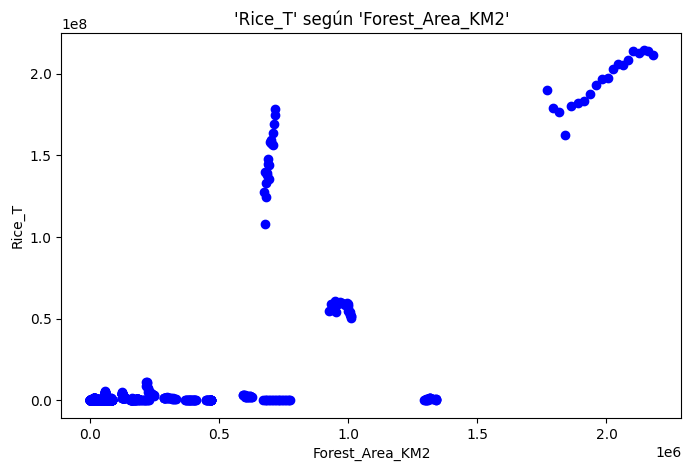

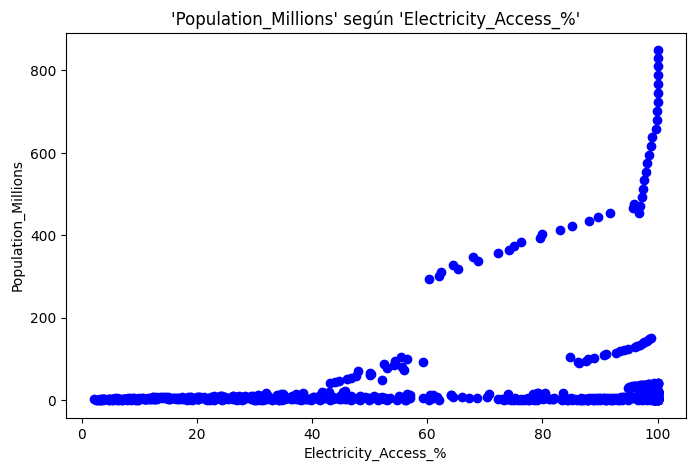


Se decide usar la regresión no lineal con la función sigmoide. Lo anterior
se justifica ya que esta forma de S (sigmoide) se ajusta bien a los datos don-
de hay un crecimiento inicial lento, seguido de un aumento rápido y finalmente
una estabilización.

Descripción Rice_T según Forest_Area_KM2:
	La gráfica muestra que la cantidad de arroz (Rice_T) inicialmente aumenta muy lenta-
	mente a medida que aumenta el área forestal (Forest_Area_KM2). Hay un incremento más
	rápido en la cantidad de arroz alrededor del valor intermedio del área forestal. Fi-
	nalmente, la cantidad de arroz parece estabilizarse a niveles altos del área forestal.

Descripción Population_Millions según Electricity_Access_%:
	La gráfica muestra que la población (Population_Millions) inicialmente es baja inclu-
	so cuando el acceso a la electricidad (Electricity_Access_%) aumenta. Luego, hay un
	aumento significativo en la población a medida que el acceso a la electricidad alcan-
	za niveles intermedios. Finalmente, 

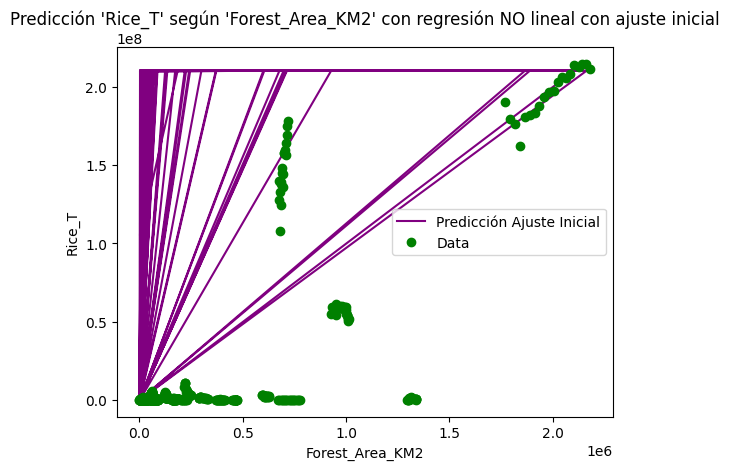

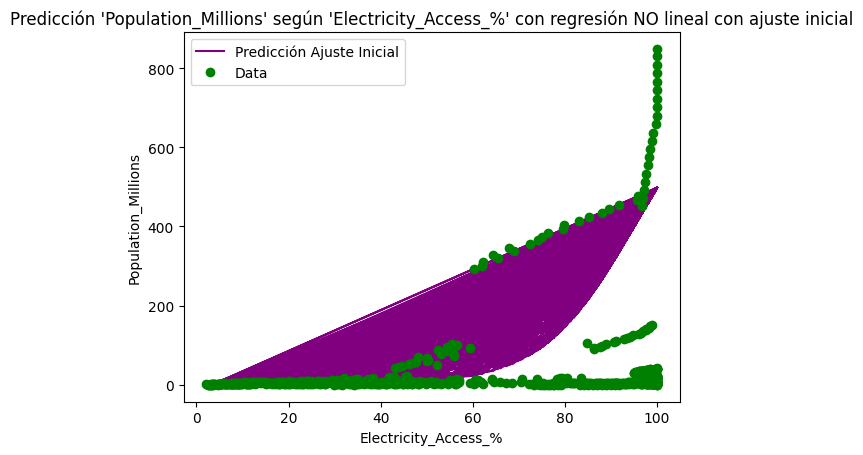

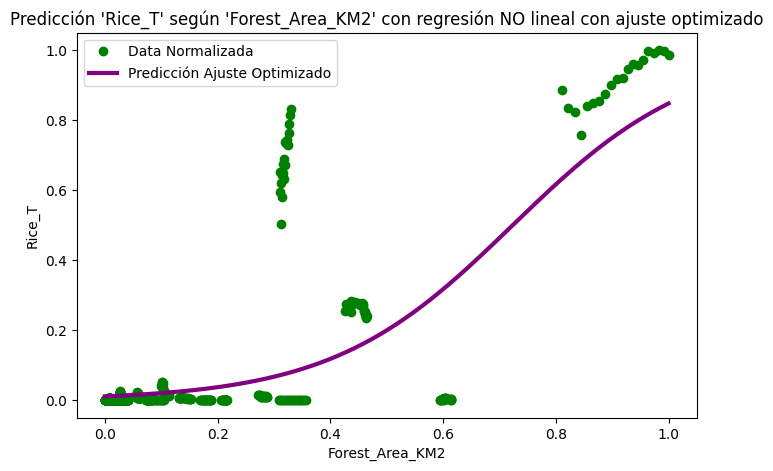

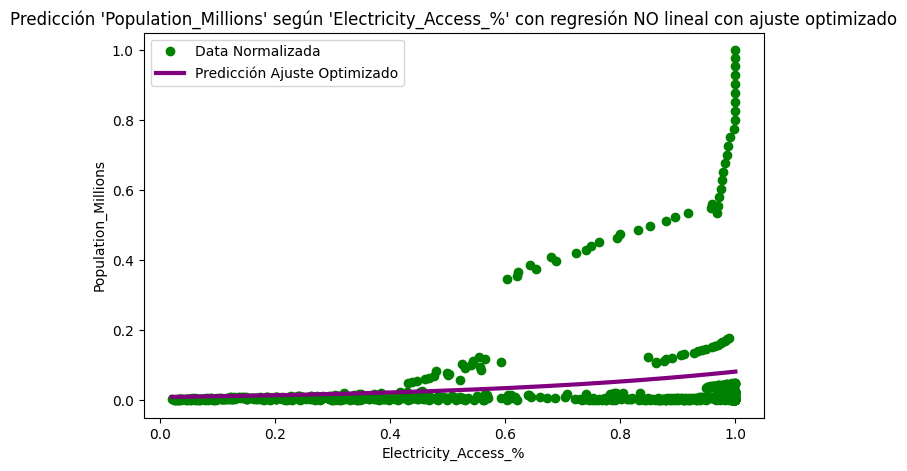

In [159]:

#----------------------------SCATTER-PLOT ENTRE 2 VARIABLES---------------------------------------------------------------
def scatter_plot(values_x, values_y, label_x, label_y, title):
    plt.figure(figsize=(8, 5))
    plt.plot(values_x, values_y, 'bo')
    plt.xlabel(label_x)
    plt.ylabel(label_y)
    plt.title(title)
    plt.show()
#-------------------------------------------------------------------------------------------------------------------------

#----------------PREDECIR Y EN BASE A X USANDO UNA FUNCION SIGMOIDE ELIGIENDO LAS CONSTANTES BETAS------------------------
def sigmoid(values_x, beta_1, beta_2):
    y = 1 / (1 + np.exp(-beta_1 * (values_x - beta_2)))
    return y
#-------------------------------------------------------------------------------------------------------------------------

#----------------MOSTRAR PRIMERA PREDICCION: la data original y el sigmoid con ajuste inicial-----------------------------
def first_pred_plot(x_og, y_og, y_pr, scalar, label_x, label_y, title):
    plt.plot(x_og, y_pr * scalar, color='purple', label='Predicción Ajuste Inicial')
    plt.plot(x_og, y_og, 'go', label='Data')
    plt.xlabel(label_x)
    plt.ylabel(label_y)
    plt.legend()
    plt.title(title)
    plt.show()
#-------------------------------------------------------------------------------------------------------------------------

#-------------MOSTRAR SEGUNDA PREDICCION: la data normalizada y el sigmoid con ajuste optimizado--------------------------
def secon_pred_plot(x_nm, y_nm, x_fit, y_fit, label_x, label_y, title):
    plt.figure(figsize=(8, 5))
    plt.plot(x_nm, y_nm, 'go', label='Data Normalizada')
    plt.plot(x_fit, y_fit, linewidth=3.0, color='purple', label='Predicción Ajuste Optimizado')
    plt.legend(loc='best')
    plt.xlabel(label_x)
    plt.ylabel(label_y)
    plt.title(title)
    plt.show()
#-------------------------------------------------------------------------------------------------------------------------

#-------------------------------------------------------------------------------------------------------------------------
def main_02():
    fore_og = my_data['Forest_Area_KM2'].values  # valores originales de la variable 'Forest_Area_KM2'
    rice_og = my_data['Rice_T'].values  # valores originales de la variable 'Rice_T'
    elec_og = my_data['Electricity_Access_%'].values  # valores originales de la variable 'Electricity_Access_%'
    popu_og = my_data['Population_Millions'].values  # valores originales de la variable 'Population_Millions'
    
    scatter_plot(fore_og, rice_og, 'Forest_Area_KM2', 'Rice_T', "'Rice_T' según 'Forest_Area_KM2'")
    scatter_plot(elec_og, popu_og, 'Electricity_Access_%', 'Population_Millions', "'Population_Millions' según 'Electricity_Access_%'")
    
    print("\nSe decide usar la regresión no lineal con la función sigmoide. Lo anterior")
    print("se justifica ya que esta forma de S (sigmoide) se ajusta bien a los datos don-")
    print("de hay un crecimiento inicial lento, seguido de un aumento rápido y finalmente")
    print("una estabilización.\n")
    print("Descripción Rice_T según Forest_Area_KM2:")
    print("\tLa gráfica muestra que la cantidad de arroz (Rice_T) inicialmente aumenta muy lenta-")
    print("\tmente a medida que aumenta el área forestal (Forest_Area_KM2). Hay un incremento más")
    print("\trápido en la cantidad de arroz alrededor del valor intermedio del área forestal. Fi-")
    print("\tnalmente, la cantidad de arroz parece estabilizarse a niveles altos del área forestal.\n")
    print("Descripción Population_Millions según Electricity_Access_%:")
    print("\tLa gráfica muestra que la población (Population_Millions) inicialmente es baja inclu-")
    print("\tso cuando el acceso a la electricidad (Electricity_Access_%) aumenta. Luego, hay un")
    print("\taumento significativo en la población a medida que el acceso a la electricidad alcan-")
    print("\tza niveles intermedios. Finalmente, la estabilización parece no cumplirse del todo.\n")


    beta_1 = 0.10  # ajuste inicial beta_1 basado en intuición
    beta_2 = 3000.0  # ajuste inicial beta_2 basado en intuición
    rice_p1 = sigmoid(fore_og, beta_1, beta_2)  # prediccion 'Rice_T' con ajuste inicial
    beta_1 = 0.10  # ajuste inicial beta_1 basado en intuición
    beta_2 = 95.0  # ajuste inicial beta_2 basado en intuición
    popu_p1 = sigmoid(elec_og, beta_1, beta_2)  # prediccion 'Population_Millions' con ajuste inicial
    
    scalar = 210000000  # ajustar respecto al eje y
    label_x = 'Forest_Area_KM2'
    label_y = 'Rice_T'
    title = "Predicción 'Rice_T' según 'Forest_Area_KM2' con regresión NO lineal con ajuste inicial"
    first_pred_plot(fore_og, rice_og, rice_p1, scalar, label_x, label_y, title)  # visualizar regresion no lineal con ajuste inicial

    scalar = 800  # ajustar respecto al eje y
    label_x = 'Electricity_Access_%'
    label_y = 'Population_Millions'
    title = "Predicción 'Population_Millions' según 'Electricity_Access_%' con regresión NO lineal con ajuste inicial"
    first_pred_plot(elec_og, popu_og, popu_p1, scalar, label_x, label_y, title)  # visualizar regresion no lineal con ajuste inicial

    fore_nm = fore_og / max(fore_og)  # normalizar valores de la variable 'Forest_Area_KM2'
    rice_nm = rice_og / max(rice_og)  # normalizar valores de la variable 'Rice_T'
    elec_nm = elec_og / max(elec_og)  # normalizar valores de la variable 'Electricity_Access_%'
    popu_nm = popu_og / max(popu_og)  # normalizar valores de la variable 'Population_Millions'

    popt, pcov = curve_fit(sigmoid, fore_nm, rice_nm)  # obtener parametros optimos, regresión normalizada Forest_Area_KM2 y Rice_T
    beta1_rice = popt[0]  # sacar beta 1 de los parametros optimos
    beta2_rice = popt[1]  # sacar beta 2 de los parametros optimos
    popt, pcov = curve_fit(sigmoid, elec_nm, popu_nm)  # obtener parametros optimos, regresión normalizada Electricity_Access_% y Population_Millions
    beta1_popu = popt[0]  # sacar beta 1 de los parametros optimos'Electricity_Access_%'
    beta2_popu = popt[1]  # sacar beta 2 de los parametros optimos   

    min_val_fore = min(fore_og)  # obtener el valor minimo que toma la variable Forest_Area_KM2
    max_val_fore = max(fore_og)  # obtener el valor maximo que toma la variable Forest_Area_KM2
    num_val_fore = len(fore_og)  # obtener el numero de valores que toma la variable Forest_Area_KM2
    min_val_elec = min(elec_og)  # obtener el valor minimo que toma la variable Electricity_Access_%
    max_val_elec = max(elec_og)  # obtener el valor maximo que toma la variable Electricity_Access_%
    num_val_elec = len(elec_og)  # obtener el numero de valores que toma la variable Electricity_Access_%

    fore_fit = np.linspace(min_val_fore, max_val_fore, num_val_fore) / max_val_fore  # ajuste optimizado para Forest_Area_KM2
    elec_fit = np.linspace(min_val_elec, max_val_elec, num_val_elec) / max_val_elec  # ajuste optimizado para Electricity_Access_%    

    rice_fit = sigmoid(fore_fit, beta1_rice, beta2_rice)  # prediccion 'Rice_T' con funcion sigmoide con ajuste optimizado
    popu_fit = sigmoid(elec_fit, beta1_popu, beta2_popu)  # prediccion 'Population_Millions' con funcion sigmoide con ajuste optimizado

    label_x = 'Forest_Area_KM2'
    label_y = 'Rice_T'
    title = "Predicción 'Rice_T' según 'Forest_Area_KM2' con regresión NO lineal con ajuste optimizado"
    secon_pred_plot(fore_nm, rice_nm, fore_fit, rice_fit, label_x, label_y, title) # visualizar regresion no lineal con ajuste optimizado

    label_x = 'Electricity_Access_%'
    label_y = 'Population_Millions'
    title = "Predicción 'Population_Millions' según 'Electricity_Access_%' con regresión NO lineal con ajuste optimizado"
    secon_pred_plot(elec_nm, popu_nm, elec_fit, popu_fit, label_x, label_y, title)  # visualizar regresion no lineal con ajuste optimizado
#-------------------------------------------------------------------------------------------------------------------------

#------------------------------------------------INVOCAR------------------------------------------------------------------
main_02()
#-------------------------------------------------------------------------------------------------------------------------


## 3. (50%) 

### Instrucción
- Cuando analizamos datos, muchas veces queremos realizar clasificaciones. Por 
ejemplo, podemos entrenar un modelo que determine la raza de un perro a partir de sus 
características o predecir si una persona va a realizar una donación a partir de sus 
características psicológicas. Identifique en su base de datos una o más variables que 
desee predecir que no sea numérica. Por ejemplo, la raza de un perro, el hecho de realizar 
donación o no, la presencia o ausencia de una enfermedad, o la región del mundo en la 
que se encuentra. También puede utilizar categorías similares a las de ANOVA de la 
entrega anterior. Utilizando este tutorial, inves gue sobre el aprendizaje de máquina 
(machine learning) para crear y entrenar un modelo que u lice los valores de varias 
variables para predecir la o las variables anteriormente escogidas. Procure entrenar el 
modelo con un subconjunto de los datos ( tipicamente 90% de los datos, seleccionados 
aleatoriamente) y realizar pruebas con otro subconjunto ( picamente el 10% restante). 
Evalúe el porcentaje de predicciones correctas con este modelo. Para ello, obtenga el 
promedio en varias ejecuciones (donde se entrena el modelo con datos dis ntos debido a 
la muestra aleatoria). Optimice el modelo realizando algunas modificaciones. Explique 
todas las etapas realizadas y documente el ajuste de los modelos generados. Para los 
modelos utilizados, puede utilizar redes neuronales artificiales u otras aproximaciones. 

Para este caso vamos a predecir la variable categorica Size_Population con otras variables(evidentemente vamos a omitir Populations_Millons)

In [160]:
def check_column_exists(df, column_name):
    """Check if a column exists in the DataFrame."""
    return column_name in df.columns

def encode_labels(df, column_name):
    """Encode labels in a specific column using LabelEncoder."""
    label_encoder = LabelEncoder()
    df[column_name] = label_encoder.fit_transform(df[column_name])
    return label_encoder

def select_features(df, feature_columns):
    """Select feature columns and the target column 'Size_Population'."""
    X = df[feature_columns]  # Features
    y = df['Size_Population']  # Target
    return X, y

def split_data(X, y, test_size=0.1, random_state=42):
    """Split data into training and testing sets."""
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

def standardize_data(X_train, X_test):
    """Standardize features using StandardScaler."""
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test

def train_random_forest(X_train, y_train, n_estimators=100, random_state=42):
    """Train a Random Forest classifier."""
    model = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)
    model.fit(X_train, y_train)
    return model

def evaluate_model(model, X_test, y_test, label_encoder):
    """Evaluate the trained model on the test set."""
    y_pred = model.predict(X_test)
    class_names = label_encoder.inverse_transform([0, 1, 2])  # Adjust according to the number of classes
    print(classification_report(y_test, y_pred, target_names=class_names))

def main_08(df):
    """Main function to orchestrate the data preprocessing, model training, and evaluation."""
    column_name = 'Size_Population'
    feature_columns = ['Coal', 'Oil', 'Cement']  # Features to use
    
    if check_column_exists(df, column_name):
        label_encoder = encode_labels(df, column_name)  # Encode labels in 'Size_Population'
        X, y = select_features(df, feature_columns)  # Select features and target
        X_train, X_test, y_train, y_test = split_data(X, y)  # Split data into training and testing sets
        X_train, X_test = standardize_data(X_train, X_test)  # Standardize the features
        model = train_random_forest(X_train, y_train)  # Train a Random Forest model
        evaluate_model(model, X_test, y_test, label_encoder)  # Evaluate the model
    else:
        print(f"Column '{column_name}' does not exist in the DataFrame")  # Handle case where column is missing

# Example usage with your DataFrame 'my_data'
main_08(my_data)



              precision    recall  f1-score   support

       Large       1.00      0.96      0.98        24
      Medium       0.95      0.95      0.95        40
       Small       0.83      0.91      0.87        11

    accuracy                           0.95        75
   macro avg       0.93      0.94      0.93        75
weighted avg       0.95      0.95      0.95        75



En la salida se encuentra el informe de clasificación generado por classification_report de sklearn.metrics. Este informe muestra varias métricas de evaluación para cada clase en el conjunto de datos de prueba.

Precision (Precisión): La precisión es la proporción de verdaderos positivos entre todos los casos positivos predichos. Es una medida de la exactitud de las predicciones positivas.

Recall (Sensibilidad o Recall): La sensibilidad es la proporción de verdaderos positivos entre todos los casos positivos reales. Es una medida de la capacidad del modelo para capturar todos los casos positivos.

F1-score: El F1-score es la media armónica de la precisión y la sensibilidad. Proporciona un equilibrio entre precisión y sensibilidad y es especialmente útil cuando se necesita un balance entre las dos.

Support (Soporte): El soporte es el número de ocurrencias reales de cada clase en el conjunto de prueba.

Interpretación de los Resultados
Clase 'Large'
Precision: 1.00
Recall: 0.96
F1-score: 0.98
Support: 24
El modelo identificó correctamente todos los ejemplos de la clase 'Large' sin cometer errores. Tiene una precisión y sensibilidad perfectas para esta clase.

Clase 'Medium'
Precision: 0.95
Recall: 0.95
F1-score: 0.95
Support: 40
El modelo tiene una alta precisión y sensibilidad para la clase 'Medium', con muy pocos errores. La mayoría de las predicciones fueron correctas.

Clase 'Small'
Precision: 0.83
Recall: 0.91
F1-score: 0.87
Support: 11
La clase 'Small' tiene una precisión y sensibilidad ligeramente inferiores en comparación con las otras clases. Esto podría deberse al menor número de ejemplos disponibles para esta clase, lo que puede hacer que sea más difícil para el modelo aprender a identificarla correctamente.

Métricas Globales
Accuracy (Exactitud): 0.95
La exactitud es la proporción de todas las predicciones correctas (verdaderos positivos y verdaderos negativos) entre el total de predicciones. Una exactitud del 97% significa que el modelo predijo correctamente el 95% de los ejemplos del conjunto de prueba.

Macro Avg (Promedio Macro):
Precision: 0.93
Recall: 0.94
F1-score: 0.93
El promedio macro calcula la métrica promedio para cada clase y luego promedia estas métricas. Es útil para evaluar el rendimiento del modelo en clases desbalanceadas.

Weighted Avg (Promedio Ponderado):
Precision: 0.95
Recall: 0.95
F1-score: 0.95
El promedio ponderado considera el soporte de cada clase al calcular el promedio de las métricas. Es útil cuando hay un desequilibrio en el número de ejemplos entre las clases.

En general, el modelo tiene un buen rendimiento con altas precisiones, sensibilidades y F1-scores, especialmente para las clases 'Large' y 'Medium'. La clase 'Small' tiene un rendimiento ligeramente inferior pero aún muy bueno.

### Evaluacion de Predicciones correctas

Para evaluar el rendimiento del modelo de clasificación entrenado, haremos diez corridas calculando la media de aciertos en el 10% de prueba pero entrenandolo cada vez con distintos datos.

In [161]:
from sklearn.metrics import accuracy_score
import numpy as np

def check_column_exists(df, column_name):
    """Check if a column exists in the DataFrame."""
    return column_name in df.columns

def encode_labels(df, column_name):
    """Encode labels in a specific column using LabelEncoder."""
    label_encoder = LabelEncoder()
    df[column_name] = label_encoder.fit_transform(df[column_name])
    return label_encoder

def select_features(df, feature_columns):
    """Select feature columns and the target column 'Size_Population'."""
    X = df[feature_columns]
    y = df['Size_Population']
    return X, y

def split_data(X, y, test_size=0.1, random_state=42):
    """Split data into training and testing sets."""
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

def standardize_data(X_train, X_test):
    """Standardize features using StandardScaler."""
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test

def train_random_forest(X_train, y_train, n_estimators=100, random_state=42):
    """Train a Random Forest classifier."""
    model = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)
    model.fit(X_train, y_train)
    return model

def evaluate_model(model, X_test, y_test):
    """Evaluate the trained model on the test set."""
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

def run_evaluation(df, iterations=10):
    """Run evaluation process multiple times and print average accuracy."""
    column_name = 'Size_Population'
    feature_columns = ['Coal', 'Oil', 'Cement']
    
    if check_column_exists(df, column_name):
        label_encoder = encode_labels(df, column_name)
        accuracies = []
        
        for i in range(iterations):
            X, y = select_features(df, feature_columns)
            X_train, X_test, y_train, y_test = split_data(X, y, random_state=None)  # Random state is None for different splits
            X_train, X_test = standardize_data(X_train, X_test)
            model = train_random_forest(X_train, y_train)
            accuracy = evaluate_model(model, X_test, y_test)
            accuracies.append(accuracy)
        
        mean_accuracy = np.mean(accuracies)
        print(f"Promedio de precisión en {iterations} ejecuciones: {mean_accuracy:.2%}")
    else:
        print(f"Column '{column_name}' does not exist in the DataFrame")

# Assume 'my_data' is your DataFrame
run_evaluation(my_data, iterations=10)


Promedio de precisión en 10 ejecuciones: 90.27%


#### Optmizacion:

La optimizacion se realizara añadiendo mas variables de significancia al modelo que se entrena, en total seran ['H2O_Extraction_Billions', 'Electricity_Access_%', 'Forest_Area_KM2', 'Coal', 'Oil', 'Cement', 'Rice_T'] .


In [162]:

def evaluate_modelO(model, X_test, y_test):
    # Evaluate the trained model on the test set and print a classification report
    y_pred = model.predict(X_test)
    target_names = ['Small', 'Medium', 'Large']
    print(classification_report(y_test, y_pred, target_names=target_names))
    return accuracy_score(y_test, y_pred)

def run_evaluationO(df, iterations=10):
    # Perform evaluation process over multiple iterations and print average accuracy
    column_name = 'Size_Population'
    feature_columns = ['H2O_Extraction_Billions', 'GHG_Emissions_KT', 'Forest_Area_KM2', 'Coal', 'Oil', 'Cement', 'Rice_T']
    
    if check_column_exists(df, column_name):
        accuracies = []
        
        for i in range(iterations):
            # Perform evaluation for each iteration
            X, y = select_features(df, feature_columns)
            X_train, X_test, y_train, y_test = split_data(X, y, random_state=None)  # Random state is None for different splits
            X_train, X_test = standardize_data(X_train, X_test)
            model = train_random_forest(X_train, y_train)
            accuracy = evaluate_modelO(model, X_test, y_test)
            accuracies.append(accuracy)
            
        # Calculate and print the mean accuracy over all iterations
        mean_accuracy = np.mean(accuracies)
        print(f"Promedio de precisión en {iterations} ejecuciones del modelo optimizado: {mean_accuracy:.2%}")
    else:
        print(f"Column '{column_name}' does not exist in the DataFrame")

# Assume 'my_data' is your DataFrame
run_evaluationO(my_data, iterations=1)



              precision    recall  f1-score   support

       Small       1.00      1.00      1.00        29
      Medium       1.00      0.96      0.98        27
       Large       0.95      1.00      0.97        19

    accuracy                           0.99        75
   macro avg       0.98      0.99      0.99        75
weighted avg       0.99      0.99      0.99        75

Promedio de precisión en 1 ejecuciones del modelo optimizado: 98.67%



En general, el modelo optimizado tiene un excelente rendimiento con altas precisiones, sensibilidades y F1-scores, especialmente para las clases 'Large' y 'Medium'.